In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
from tensorflow.python.framework import ops
import math

%matplotlib inline

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
X_train = mnist.train.images
y_train = mnist.train.labels
X_val = mnist.validation.images
y_val = mnist.validation.labels
X_test = mnist.test.images
y_test = mnist.test.labels

X_train.shape
y_train.shape

(55000, 10)

In [13]:
X_train = X_train.reshape(X_train.shape[0],-1).T
y_train = y_train.reshape(y_train.shape[0],-1).T
X_val = X_val.reshape(X_val.shape[0],-1).T
y_val = y_val.reshape(y_val.shape[0],-1).T
X_test = X_test.reshape(X_test.shape[0],-1).T
y_test = y_test.reshape(y_test.shape[0],-1).T

In [43]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_test.shape)
print('Number a training example: ' + str(X_train.shape[1]))

(784, 55000)
(10, 55000)
(784, 5000)
(784, 10000)
(10, 10000)
Number a training example: 55000


In [15]:
def placeholder_creation(n_x,n_y):
    X = tf.placeholder(tf.float32, shape = [n_x,None], name = 'X')
    Y = tf.placeholder(tf.float32, shape = [n_y,None], name = 'Y')
    return X,Y


def initialize_parameters_deep(layer_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the dimensions of each layer in our network
    
    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    bl -- bias vector of shape (layer_dims[l], 1)
    """
    
    np.random.seed(1)
    parameters = {}
    L = len(layer_dims)            # number of layers in the network

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1]) #*0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

def initialize_parameters():
    W1 = tf.get_variable('W1',[128,784], initializer = tf.contrib.layers.xavier_initializer(seed = 3))
    b1 = tf.get_variable('b1',[128,1], initializer = tf.zeros_initializer())
    W2 = tf.get_variable('W2',[40,128], initializer = tf.contrib.layers.xavier_initializer(seed = 3))
    b2 = tf.get_variable('b2', [40,1], initializer = tf.zeros_initializer())
    W3 = tf.get_variable('W3',[10,40], initializer = tf.contrib.layers.xavier_initializer(seed = 3))
    b3 = tf.get_variable('b3',[10,1], initializer = tf.zeros_initializer())
    parameters = {
        'W1':W1,
        'b1':b1,
        'W2':W2,
        'b2':b2,
        'W3':W3,
        'b3':b3
    }
    return parameters

def forward_prop(X,parameters):
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    Z1 = tf.add(tf.matmul(W1,X),b1)
    A1 = tf.nn.relu(Z1)
    Z2 = tf.add(tf.matmul(W2,A1),b2)
    A2 = tf.nn.relu(Z2)
    Z3 = tf.add(tf.matmul(W3,A2),b3)
    return Z3 

def compute_cost(Z3,Y):
    logits = tf.transpose(Z3)
    labels = tf.transpose(Y)
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = labels))
    return cost 



In [16]:
tf.reset_default_graph()
with tf.Session() as sess:
    parameters = initialize_parameters()
    print("W1 = " + str(parameters["W1"]))
    print("b1 = " + str(parameters["b1"]))
    print("W2 = " + str(parameters["W2"]))
    print("b2 = " + str(parameters["b2"]))

W1 = <tf.Variable 'W1:0' shape=(128, 784) dtype=float32_ref>
b1 = <tf.Variable 'b1:0' shape=(128, 1) dtype=float32_ref>
W2 = <tf.Variable 'W2:0' shape=(40, 128) dtype=float32_ref>
b2 = <tf.Variable 'b2:0' shape=(40, 1) dtype=float32_ref>


In [17]:
def random_mini_batches(X, Y, mini_batch_size = 32, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (1, number of examples)
    mini_batch_size -- size of the mini-batches, integer
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    np.random.seed(seed)            # To make your "random" minibatches the same as ours
    m = X.shape[1]                  # number of training examples
    mini_batches = []
        
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((Y.shape[0],m))
    
    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    
    
    for k in range(0, num_complete_minibatches):
        ### START CODE HERE ### (approx. 2 lines)
        mini_batch_X = shuffled_X[:, k * mini_batch_size : (k + 1) * mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : (k + 1) * mini_batch_size]
        ### END CODE HERE ###
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)     
    if m % mini_batch_size != 0:
        ### START CODE HERE ### (approx. 2 lines)
        mini_batch_X = shuffled_X[:, mini_batch_size * num_complete_minibatches : m]
        mini_batch_Y = shuffled_Y[:, mini_batch_size * num_complete_minibatches : m]
        ### END CODE HERE ###
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches



In [18]:
def model(X_train, y_train, X_val, y_val, learning_rate = 0.001, num_epochs = 1500, minibatch_size = 32 , print_cost = True):
    ops.reset_default_graph()
    tf.set_random_seed(3)
    seed = 3
    (n_x,m) = X_train.shape
    n_y = y_train.shape[0]
    costs = []
    
    X,Y = placeholder_creation(n_x,n_y)
    
    parameters = initialize_parameters()
    
    Z3 = forward_prop(X,parameters)
    
    cost = compute_cost(Z3, Y)
    
    optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(cost)
    init = tf.global_variables_initializer()
    
    with tf.Session() as sess:
        sess.run(init)
        for epoch in range(num_epochs):
            epoch_cost = 0.
            num_minibatches = int(m/minibatch_size)
            seed = seed + 1 
            minibatches = random_mini_batches(X_train,y_train,minibatch_size, seed)
            for minibatch in minibatches:
                (minibatch_X,minibatch_Y) = minibatch
                _ , minibatch_cost = sess.run([optimizer,cost], feed_dict = {X: minibatch_X, Y: minibatch_Y})
                epoch_cost += minibatch_cost/num_minibatches
            if print_cost == True and epoch % 100 == 0 :
                print('Cost after epoch %i: %f' %(epoch, epoch_cost))
            if print_cost ==True and epoch%5 == 0:
                costs.append(epoch_cost)
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iteration (per tens)')
        plt.title('Learning rate = ' + str(learning_rate))
        plt.show()
        
        parameters = sess.run(parameters)
        print('Paramateres have been trained')
        
        correct_prediction = tf.equal(tf.argmax(Z3),tf.argmax(Y))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))
        
        print('train', accuracy.eval({X:X_train, Y:y_train}))
        print('eval',accuracy.eval({X:X_val, Y:y_val}))
        
    return parameters

In [21]:
def predict(X, parameters):
    
    W1 = tf.convert_to_tensor(parameters["W1"])
    b1 = tf.convert_to_tensor(parameters["b1"])
    W2 = tf.convert_to_tensor(parameters["W2"])
    b2 = tf.convert_to_tensor(parameters["b2"])
    W3 = tf.convert_to_tensor(parameters["W3"])
    b3 = tf.convert_to_tensor(parameters["b3"])
    
    params = {"W1": W1,
              "b1": b1,
              "W2": W2,
              "b2": b2,
              "W3": W3,
              "b3": b3}
    
    x = tf.placeholder("float", [784, X.shape[1]])
    
    z3 = forward_propagation_for_predict(x, params)
    p = tf.argmax(z3)
    
    sess = tf.Session()
    prediction = sess.run(p, feed_dict = {x: X})
        
    return prediction

def forward_propagation_for_predict(X, parameters):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3'] 
                                                           # Numpy Equivalents:
    Z1 = tf.add(tf.matmul(W1, X), b1)                      # Z1 = np.dot(W1, X) + b1
    A1 = tf.nn.relu(Z1)                                    # A1 = relu(Z1)
    Z2 = tf.add(tf.matmul(W2, A1), b2)                     # Z2 = np.dot(W2, a1) + b2
    A2 = tf.nn.relu(Z2)                                    # A2 = relu(Z2)
    Z3 = tf.add(tf.matmul(W3, A2), b3)                     # Z3 = np.dot(W3,Z2) + b3
    
    return Z3

Cost after epoch 0: 1.877333
Cost after epoch 100: 0.113026
Cost after epoch 200: 0.058836
Cost after epoch 300: 0.034412
Cost after epoch 400: 0.021098
Cost after epoch 500: 0.013456
Cost after epoch 600: 0.008974
Cost after epoch 700: 0.006295
Cost after epoch 800: 0.004638
Cost after epoch 900: 0.003579
Cost after epoch 1000: 0.002869
Cost after epoch 1100: 0.002365
Cost after epoch 1200: 0.001993
Cost after epoch 1300: 0.001710
Cost after epoch 1400: 0.001492


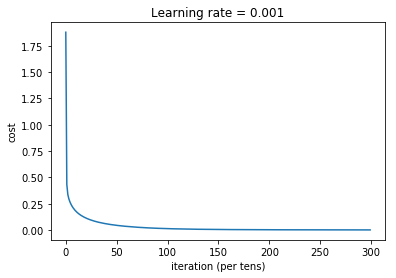

Paramateres have been trained
train 1.0
eval 0.9796


In [20]:
parameters = model(X_train, y_train, X_val, y_val)

In [53]:
pred = predict(X_test, parameters)
pp = np.argmax(y_test, axis = 0)

acc = np.sum(np.where(pp==pred,1,0))/10000
print('Accuracy on test set is:' + str(acc))

Accuracy on test set is:0.9764
